## TODO
<input type="checkbox" disabled> __Predict Log Population Densities using same keras baseline__
<input type="checkbox" disabled> __Check dataloader keras__
<input type="checkbox" disabled> __Device filter inputs__
<input type="checkbox" disabled> __SES Classification (feed extreme classes i.e, 1 and 5)__

# TensorFlow: keras_baseline.py

## Required Inputs

In [2]:
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD, Adam
import pandas as pd
import os
from tqdm import tqdm as tqdmn
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras import metrics
from keras import backend as K
from keras.models import Model
import sys
from skimage import io
import multiprocessing
from joblib import Parallel, delayed

# Global paths
BASE_DIR = "/warehouse/COMPLEXNET/jlevyabi/"
SAT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/esa/URBAN_ATLAS/"
CENSUS_DIR = BASE_DIR + 'REPLICATE_LINGSES/data_files/census_data/'
UA_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/land_ua_esa/FR/"
OUTPUT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/outputs/esa_URBAN_ATLAS_FR/"
MODEL_OUTPUT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/outputs/model_data/resnet50_keras/"
sys.path.append(BASE_DIR + "SATELSES/equirect_proj_test/cnes/python_files/")
from generate_fr_ua_vhr_data import *

# Global variables
NB_CLASSES = 5
PATIENCE_BEFORE_STOPPING = 5
PATIENCE_BEFORE_LOWERING_LR = 3
TRAIN_TEST_FRAC = .8
VAL_SPLIT = .25
BATCH_SIZE = 16
IMG_SIZE = (400, 400)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 2
INITIAL_LR = 0.001
CPU_COUNT = multiprocessing.cpu_count()
CPU_FRAC = .7
CPU_USE = int(CPU_FRAC*CPU_COUNT)

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

## Analysis of Data fed to Model

### Location - Image : Is image labeled with idINSPIRE corresponding to real idINSPIRE location?

__All the images correspond to the locations they are supposed to be taken from (Google Maps checked out)__

There are however things that I've noticed:
- Most images are taken from rural areas 
- Some contain too many dark areas corresponding to cells taken at the edge of the merged tiles
- Some idINSPIRE cells correspond to multiple images due to overlapping merged tiles
- Haze / Color scaling affects color of some images.

In [ ]:
image_files = [os.path.join(inter_sat_dir,im_file) for inter_sat_dir in tqdmn(os.listdir(OUTPUT_DIR) )
               for im_file in os.listdir(OUTPUT_DIR + inter_sat_dir) if im_file.endswith(".png")]

im_df = pd.DataFrame()
im_df["path2im"] = image_files
im_df["idINSPIRE"] = [k.split("/")[-1].split(".")[0].split("_")[-1] for k in image_files]
car_df = generate_car_census_data()

100%|██████████| 116/116 [00:01<00:00, 102.98it/s]


In [ ]:
nb = 4
test_image_location = im_df.sample(nb)
test_image_location = gpd.GeoDataFrame(pd.merge(test_image_location,car_df,on="idINSPIRE"),crs=car_df.crs)
test_image_location = test_image_location.to_crs({"init":"epsg:4326"})
test_image_location["lat"] = [list(x.centroid.coords)[0][1] for x in test_image_location.geometry]
test_image_location["lon"] = [list(x.centroid.coords)[0][0] for x in test_image_location.geometry]

In [ ]:
test_image_location[["lat","lon"]]

In [ ]:
f,axes = plt.subplots(2,2,figsize=(10,10))
plt.setp(axes,xticks=[],yticks=[])
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=.05,hspace=.05)
for i in np.arange(nb):
    row = test_image_location.iloc[i]
    im = io.imread(OUTPUT_DIR + row.path2im)
    im = (im-np.min(im))/(np.max(im)-np.min(im))
    axes[i//2,i%2].imshow(im)
    axes[i//2,i%2].text(x=200,y=200,s="%.6f,%.6f"%(row.lat,row.lon),color="white",
                               bbox=dict(facecolor='red', alpha=0.5))

### Location - SES : Is idINSPIRE rightly assigned to correct SES ?
__All of them seem to checkout (checked with #francepixel)__

In [ ]:
pre_dic = pd.read_csv(OUTPUT_DIR + "../census_data/squares_to_ses.csv" )

In [ ]:
full_insee_df = generate_complete_census_data()
pre_dic = pd.read_csv(OUTPUT_DIR + "../census_data/squares_to_ses.csv" )

In [ ]:
check_data = full_insee_df[["idINSPIRE","geometry","income"]].sample(10).to_crs({"init":"epsg:4326"})
check_data["lat"] = [list(x.centroid.coords)[0][1] for x in check_data.geometry]
check_data["lon"] = [list(x.centroid.coords)[0][0] for x in check_data.geometry]

In [ ]:
pd.merge(check_data,pre_dic.drop(["pov_rate","i_basr","ind_c","nbcar_car"],axis=1),
         on="idINSPIRE",suffixes=("_check","_sq2ses"))

### Treatment of Raw INSEE income values
__Income classes generated by deciles of the original income distributions, seems to be ok(check plot)__

Notice however that range of income values seem to be quite narrow especially for classes not laying on the extremes. Maybe a better way to validate procedure would be to start by feeding the model only with samples on these extreme classes (both of them being different between one another by a meager 5000€/yr difference).

In [ ]:
scaler = MinMaxScaler()
pre_dic.dropna(subset=["income"],inplace=True)
scaler.fit(pre_dic.income.values.reshape(-1, 1))
pre_dic["min_max_income"] = scaler.transform(pre_dic.income.values.reshape(-1, 1))

def my_preprocessor(image):
    image = np.array(image)
    image = 255*(image - np.min(image))/(np.max(image)-np.min(image))
    return image

full_im_df = pd.merge(pre_dic,im_df,on="idINSPIRE")
full_im_df = full_im_df.sample(frac=1)

income = full_im_df.income
class_thresholds = [np.percentile(income,k) for k in np.linspace(0,100,NB_CLASSES +1 )]
x_to_class = np.digitize(income,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_CLASSES
full_im_df["treated_income"] = [ str(y-1) for y in x_to_class ]

In [ ]:
sns.stripplot(x="treated_income", y="income",
              data=full_im_df.sample(2000), jitter=True,
              alpha=.25, zorder=1);

### Generation of model feeders: Are the generators keeping the order of things?

In [ ]:
def chunks(arr, nb_splits):
    """Yield successive n-sized chunks from l."""
    order = np.linspace(start=0,stop=len(arr),num=nb_splits + 1)
    for i in range(len(order)-1):
        yield arr[int(order[i]):int(order[i+1])] 

In [ ]:
from skimage import io 
def parallel_folder_extraction(im_dir,null_thresh):
    images = []
    for path in im_dir:
        image = io.imread(OUTPUT_DIR + path)
        if  100*(image==0).sum()/image.size > null_thresh :
            images.append((path,False))
        else:
            images.append((path,True))
    return images

def parallel_make_dataset(im_data, null_thresh = 1):
    nb_images = len(im_data)
    pre_full = Parallel(n_jobs=CPU_USE)(
        delayed(parallel_folder_extraction)(im_arr,null_thresh=null_thresh) 
        for im_arr in tqdmn(chunks(im_data,CPU_USE)))
    return [data for pre in pre_full for data in pre]

In [ ]:
test = parallel_make_dataset(full_im_df.path2im)

In [ ]:
void_df = pd.DataFrame(test,columns=["path2im","non_void"])

In [ ]:
full_im_df = pd.merge(full_im_df,void_df,on="path2im")
#full_im_df = full_im_df[full_im_df.non_void]
full_im_df.reset_index(drop=True,inplace=True)
train_test_split = np.floor(full_im_df.shape[0]*TRAIN_TEST_FRAC).astype(int)
train_im_df = full_im_df.iloc[:train_test_split]
test_im_df = full_im_df.iloc[train_test_split:]

train_image_count = int(train_test_split*(1-VAL_SPLIT))
val_image_count = int(train_test_split*VAL_SPLIT)
test_image_count = test_im_df.shape[0]

train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=my_preprocessor,
                                   horizontal_flip=True,validation_split=VAL_SPLIT)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=my_preprocessor)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_im_df,
        directory=OUTPUT_DIR,x_col="path2im", y_col="treated_income",target_size=IMG_SIZE,
        color_mode ="rgb",batch_size=BATCH_SIZE, interpolation="bicubic",subset="training", class_mode='categorical')

val_generator = train_datagen.flow_from_dataframe(train_im_df,
        directory=OUTPUT_DIR, x_col="path2im", y_col="treated_income",target_size=IMG_SIZE,
        color_mode ="rgb",batch_size=BATCH_SIZE,interpolation="bicubic", subset="validation",class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_im_df,
        directory=OUTPUT_DIR,x_col="path2im",y_col="treated_income",target_size=IMG_SIZE,
        color_mode ="rgb",seed = 4,batch_size=BATCH_SIZE,interpolation="bicubic",class_mode='categorical')

###  Inputs Sanity Check

In [ ]:
def make_grid(im_batch, lab_batch, nrow):
    # make the mini-batch of images into a grid
    batch_size, w, h, c = im_batch.shape
    nb_cols = min(nrow, batch_size)
    nb_rows = int(np.ceil(float(batch_size) / nb_cols))
    f,axes = plt.subplots(nb_rows,nb_cols,figsize=(nb_cols*3,nb_rows*3))
    plt.setp(axes,xticks=[],yticks=[])
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=.05,hspace=.05)
    k = 0
    for i_row in np.arange(nb_rows):
        for i_col in np.arange(nb_cols):
            axes[i_row,i_col].imshow(im_batch[k])
            axes[i_row,i_col].text(x=200,y=200,s="%d"%np.where(l_test[k])[0][0],#l_test[k],#
                                   color="white",
                                   bbox=dict(facecolor='red', alpha=0.5))
            k+=1
            if k >= batch_size:
                break

In [ ]:
iterize = iter(test_generator)
#info_iterize = iter(info_test_generator)

In [ ]:
i_test,l_test = next(iterize)
#par_i_test,idINSPIRE_test = next(info_iterize)

In [ ]:
make_grid(i_test,l_test,4)

### Supplementary Check : Predict # of inhabitants in square (to further validate all previous points)

In [ ]:
full_im_df["log_pop_cnt"] = np.log10(full_im_df.ind_c)
pop_dens = full_im_df["log_pop_cnt"]
dens_class_thresholds = [np.percentile(pop_dens,k) for k in np.linspace(0,100,NB_CLASSES +1 )]
x_to_class = np.digitize(pop_dens,dens_class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_CLASSES
full_im_df["treated_density"] = [ str(y-1) for y in x_to_class ]

In [ ]:
plt.hist(full_im_df.log_pop_cnt,cumulative=True,bins=50,normed=True);

In [ ]:
sns.stripplot(x="treated_density", y="log_pop_cnt",
              data=full_im_df.sample(2000), jitter=True,
              alpha=.25, zorder=1);

In [ ]:
from collections import Counter
Counter(full_im_df.treated_density.values)

In [ ]:
density_generator = test_datagen.flow_from_dataframe(dataframe=full_im_df,
        directory=OUTPUT_DIR,x_col="path2im",y_col="treated_density",target_size=IMG_SIZE,
        color_mode ="rgb",seed = 4,batch_size=BATCH_SIZE,interpolation="bicubic",class_mode='categorical')

In [ ]:
iterize = iter(density_generator)

In [ ]:
i_test,l_test = next(iterize)
make_grid(i_test,l_test,4)

## Model Analysis

In [ ]:
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 21))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def fbeta_score(y_true, y_pred, beta=1): 
    if beta < 0: 
        raise ValueError('The lowest choosable beta is zero (only precision).') 

    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0: 
        return 0 
    p = precision(y_true, y_pred) 
    r = recall(y_true, y_pred) 
    bb = beta ** 2 
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon()) 
    return fbeta_score 

def fmeasure(y_true, y_pred): 
    return fbeta_score(y_true, y_pred, beta=1) 


In [78]:
from keras.models import Model, load_model
model = load_model(
    MODEL_OUTPUT_DIR + "../UA_density/lastbest-0.hdf5",
    custom_objects= {
    "precision":precision,
    "recall":recall,
    "fbeta_score":fbeta_score,
    "fmeasure":fmeasure
    },
)

In [79]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 406, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 200, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 200, 200, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
test_generator = test_datagen.flow_from_dataframe(dataframe=full_im_df.sample(50000),
        directory=OUTPUT_DIR,x_col="path2im",y_col="treated_density",target_size=(400,400),
        color_mode ="rgb",seed = 4,batch_size=BATCH_SIZE,interpolation="bicubic",class_mode='categorical')

In [ ]:
from collections import Counter
Counter(test_generator.classes)

In [ ]:
pred_val = model.predict_generator(test_generator,verbose=1)
pred_label = np.argmax(pred_val,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
(confusion_matrix(pred_label,test_generator.classes))

In [ ]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
plot_confusion_matrix(test_generator.classes,pred_label,list(range(5)));

In [ ]:
model.predict(np.expand_dims(examining_test[0][0],axis=0))

In [ ]:
examining_test[1][3]

## WTF is going on?  Simplest Example Predicting Density 

### Imports

In [1]:
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from keras import backend as K
from keras.optimizers import SGD, Adam
import pandas as pd
import os
from tqdm import tqdm as tqdmn
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras import metrics
from keras import backend as K
from keras.models import Model, load_model
import sys
from skimage import io
import multiprocessing
from joblib import Parallel, delayed
from skimage import io 
from collections import Counter
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Global paths
BASE_DIR = "/warehouse/COMPLEXNET/jlevyabi/"
SAT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/esa/URBAN_ATLAS/"
CENSUS_DIR = BASE_DIR + 'REPLICATE_LINGSES/data_files/census_data/'
UA_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/land_ua_esa/FR/"
OUTPUT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/outputs/esa_URBAN_ATLAS_FR/"
MODEL_OUTPUT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/outputs/model_data/resnet50_keras/"
sys.path.append(BASE_DIR + "SATELSES/equirect_proj_test/cnes/python_files/")

# Global variables
NB_CLASSES = 2
PATIENCE_BEFORE_STOPPING = 5
PATIENCE_BEFORE_LOWERING_LR = 3
TRAIN_TEST_FRAC = .8
VAL_SPLIT = .25
BATCH_SIZE = 12
IMG_SIZE = (400, 400)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 2
INITIAL_LR = 0.001
CPU_COUNT = multiprocessing.cpu_count()
CPU_FRAC = .7
CPU_USE = int(CPU_FRAC*CPU_COUNT)

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

Using TensorFlow backend.


### Function Defs

In [2]:
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 21))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def fbeta_score(y_true, y_pred, beta=1): 
    if beta < 0: 
        raise ValueError('The lowest choosable beta is zero (only precision).') 

    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0: 
        return 0 
    p = precision(y_true, y_pred) 
    r = recall(y_true, y_pred) 
    bb = beta ** 2 
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon()) 
    return fbeta_score 

def fmeasure(y_true, y_pred): 
    return fbeta_score(y_true, y_pred, beta=1) 

def chunks(arr, nb_splits):
    """Yield successive n-sized chunks from l."""
    order = np.linspace(start=0,stop=len(arr),num=nb_splits + 1)
    for i in range(len(order)-1):
        yield arr[int(order[i]):int(order[i+1])] 
        
def parallel_folder_extraction(im_dir,null_thresh):
    images = []
    for path in im_dir:
        image = io.imread(OUTPUT_DIR + path)
        if  100*(image==0).sum()/image.size > null_thresh :
            images.append((path,False))
        else:
            images.append((path,True))
    return images

def parallel_make_dataset(im_data, null_thresh = 1):
    nb_images = len(im_data)
    pre_full = Parallel(n_jobs=CPU_USE)(
        delayed(parallel_folder_extraction)(im_arr,null_thresh=null_thresh) 
        for im_arr in tqdmn(chunks(im_data,CPU_USE)))
    return [data for pre in pre_full for data in pre]

def my_preprocessor(image):
    image = np.array(image)
    image = ((image - np.min(image))/(.1 + np.max(image)-np.min(image)))
    return image

def make_grid(im_batch, lab_batch, nrow):
    # make the mini-batch of images into a grid
    batch_size, w, h, c = im_batch.shape
    nb_cols = min(nrow, batch_size)
    nb_rows = int(np.ceil(float(batch_size) / nb_cols))
    f,axes = plt.subplots(nb_rows,nb_cols,figsize=(nb_cols*3,nb_rows*3))
    plt.setp(axes,xticks=[],yticks=[])
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=.05,hspace=.05)
    k = 0
    for i_row in np.arange(nb_rows):
        for i_col in np.arange(nb_cols):
            axes[i_row,i_col].imshow(im_batch[k])
            axes[i_row,i_col].text(x=200,y=200,s="%d"%np.where(l_test[k])[0][0],#l_test[k],#
                                   color="white",
                                   bbox=dict(facecolor='red', alpha=0.5))
            k+=1
            if k >= batch_size:
                break
                
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### Load Data

In [3]:
image_files = [os.path.join(inter_sat_dir,im_file) for inter_sat_dir in tqdmn(os.listdir(OUTPUT_DIR) )
               for im_file in os.listdir(OUTPUT_DIR + inter_sat_dir) if im_file.endswith(".png")]

im_df = pd.DataFrame()
im_df["path2im"] = image_files
im_df["idINSPIRE"] = [k.split("/")[-1].split(".")[0].split("_")[-1] for k in image_files]

100%|██████████| 116/116 [00:01<00:00, 103.90it/s]


In [4]:
pre_dic = pd.read_csv(OUTPUT_DIR + "../census_data/squares_to_ses.csv" )
city_dic = pd.read_csv(SAT_DIR + "../../sources/census_cells_city_boundary.csv")
info_dic = pd.merge(pre_dic,city_dic,on="idINSPIRE")

### Filter and Classifying Data

#### By City

In [5]:
info_dic.dropna(subset=["income"],inplace=True)
full_im_df = pd.merge(info_dic,im_df,on="idINSPIRE")
#full_im_df = pd.merge(info_dic[info_dic.city=="PARIS"],im_df,on="idINSPIRE")
full_im_df = full_im_df.sample(frac=1)

#### By Image

#### Define Classes

In [6]:
NB_CLASSES = 5
density = full_im_df.ind_c
full_im_df["log_pop_cnt"] = np.log10(density)
class_thresholds = [np.percentile(density,k) for k in np.linspace(0,100,NB_CLASSES +1 )]
x_to_class = np.digitize(density,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_CLASSES
full_im_df["treated_density"] = [ str(y-1) for y in x_to_class ]
#full_im_df = full_im_df[(full_im_df.treated_density!="1")&(full_im_df.treated_density!="2")] 

### Learning 

In [7]:
train_test_split = np.floor(full_im_df.shape[0]*TRAIN_TEST_FRAC).astype(int)
train_im_df = full_im_df.iloc[:train_test_split]
test_im_df = full_im_df.iloc[train_test_split:]

In [8]:
from keras.preprocessing.balanced_image import BalancedImageDataGenerator

In [9]:
train_image_count = int(train_test_split*(1-VAL_SPLIT))
val_image_count = int(train_test_split*VAL_SPLIT)
test_image_count = test_im_df.shape[0]

train_datagen = BalancedImageDataGenerator(preprocessing_function=my_preprocessor, 
                                   horizontal_flip=True,validation_split=VAL_SPLIT,vertical_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=my_preprocessor)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
        train_im_df.head(10),
        directory=OUTPUT_DIR,
        x_col="path2im",
        y_col="treated_density",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        batch_size=BATCH_SIZE,
        interpolation="bicubic",
        subset="training",
        class_mode='categorical')

Found 13 images belonging to 5 classes.


In [56]:
train_image_count = int(train_test_split*(1-VAL_SPLIT))
val_image_count = int(train_test_split*VAL_SPLIT)
test_image_count = test_im_df.shape[0]

train_datagen = BalancedImageDataGenerator(preprocessing_function=my_preprocessor, 
                                   horizontal_flip=True,validation_split=VAL_SPLIT,vertical_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=my_preprocessor)

In [61]:
test=train_im_df.head(200)

In [63]:
Counter(test.treated_density)

Counter({'0': 40, '4': 32, '1': 34, '3': 48, '2': 46})

In [64]:
train_generator = train_datagen.flow_from_dataframe(
        test,
        directory=OUTPUT_DIR,
        x_col="path2im",
        y_col="treated_density",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        batch_size=32,
        interpolation="bicubic",
        subset="training",
        class_mode='categorical')

Found 150 images belonging to 5 classes.


#### Checking Inputs

In [ ]:
iterize = iter(train_generator)

In [ ]:
i_test,l_test = next(iterize)
make_grid(i_test,l_test,4)

#### Model Defining and Training

In [ ]:
image_input = Input(shape=INPUT_SHAPE)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input,)
# add a global spatial average pooling layer
x = base_model.output
x = Flatten()(x)
# and a final logistic layer
predictions = Dense(NB_CLASSES, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=image_input, outputs=predictions)
model.compile(optimizer=Adam(lr=INITIAL_LR), loss="categorical_crossentropy", metrics=[fmeasure,recall,precision])

In [ ]:
early_stopping = EarlyStopping(patience=PATIENCE_BEFORE_STOPPING, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=PATIENCE_BEFORE_LOWERING_LR, min_lr=1e-7)
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=500, #train_image_count // BATCH_SIZE,
    epochs=1,
    validation_data=val_generator,
    validation_steps=100, #val_image_count // BATCH_SIZE,
    workers=10,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

#### Model Loading

In [ ]:
model = load_model(
    MODEL_OUTPUT_DIR + "density/lastbest-0.hdf5",
    custom_objects= {
    "precision":precision,
    "recall":recall,
    "fbeta_score":fbeta_score,
    "fmeasure":fmeasure
    },
)

In [ ]:
pred_test = model.predict_generator(test_generator, test_image_count // BATCH_SIZE + 1, workers=10, verbose=1)
y_true = test_generator.classes
y_pred = np.argmax(pred_test, axis=1)

In [ ]:
plot_confusion_matrix(y_true,y_pred,list(range(5)));

In [ ]:
def generate_gradcam(img_tensor, model, class_index, activation_layer ,input_layer):
    model_input = model.get_layer(input_layer)
    y_c = model.outputs[0][0, class_index]
    A_k = model.get_layer(activation_layer).output
    get_output = K.function([model_input], [A_k, K.gradients(y_c, A_k)[0]])
    [conv_output, grad_val] = get_output([img_tensor])
    conv_output = conv_output[0]
    grad_val = grad_val[0]
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam += w * conv_output[:, :, k]
    grad_cam = np.maximum(grad_cam, 0)
    return grad_cam, weights

In [ ]:
idx2class = {lab:k for k,lab in train_generator.class_indices.items()}

In [ ]:
import cv2
sample_data = train_im_df.sample(1).iloc[0]
sample_img = cv2.resize(my_preprocessor(cv2.imread(OUTPUT_DIR + sample_data.path2im)),IMG_SIZE)
sample_label = sample_data.treated_density

sample_input = np.expand_dims(sample_img,axis=0)
predictions = model.predict(sample_input)

In [ ]:
predicted_class = np.argmax(predictions)
conv_name = 'activation_49'
input_name = 'input_1'
grad_cam, grad_val = generate_gradcam(sample_input, model, predicted_class, conv_name, input_name)
grad_cam_rz = cv2.resize(grad_cam,sample_img.shape[:-1])

In [ ]:
f,axes = plt.subplots(1,3,figsize=(12,5))
pred_label = idx2class[predicted_class]
plt.suptitle("%s / %s (p=%.3f)"%(pred_label, sample_label, predictions[0,predicted_class]))

axes[0].imshow(sample_img)
axes[0].axis('off')

axes[1].imshow(grad_cam_rz, cmap="jet")
axes[1].axis('off')

axes[2].imshow(sample_img)
axes[2].imshow(grad_cam_rz, cmap="jet", alpha=.4)

axes[2].axis('off')
plt.show()

### Income + UA Model Training

In [2]:
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Concatenate
from keras import backend as K
from keras.optimizers import SGD, Adam
import pandas as pd
import os
from tqdm import tqdm as tqdmn
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.balanced_image import BalancedImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras import metrics
from keras import backend as K
from keras.models import Model, load_model
import csv
from sklearn.metrics import confusion_matrix, classification_report
from time import time
from keras.layers import Input
import multiprocessing
from joblib import Parallel, delayed
from skimage import io

# Global paths
BASE_DIR = "/warehouse/COMPLEXNET/jlevyabi/"
SAT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/esa/URBAN_ATLAS/"
CENSUS_DIR = BASE_DIR + 'REPLICATE_LINGSES/data_files/census_data/'
UA_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/land_ua_esa/FR/"
OUTPUT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/outputs/esa_URBAN_ATLAS_FR/"
MODEL_OUTPUT_DIR = BASE_DIR + "SATELSES/equirect_proj_test/cnes/data_files/outputs/model_data/resnet50_keras/income/"

# Global variables
NB_CLASSES = 5
PATIENCE_BEFORE_STOPPING = 5
PATIENCE_BEFORE_LOWERING_LR = 1
TRAIN_TEST_FRAC = .8
VAL_SPLIT = .25
BATCH_SIZE = 16
IMG_SIZE = (400, 400)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
MAX_EPOCH = 10
INITIAL_LR = 1e-4
CPU_COUNT = multiprocessing.cpu_count()
CPU_FRAC = .7
CPU_USE = int(CPU_FRAC*CPU_COUNT)
ADRIAN_ALBERT_THRESHOLD = .25
INSEE_AREA = 200*200

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def top_k_accuracy(y_true, y_pred,val_k):
    """ UNTESTED """
    topk_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=val_k)
    topk_acc.__name__ = 'topk_acc'
    return topk_acc(y_true, y_pred)

def neigh_k_accuracy(y_true, y_pred, val_k):
    """ UNTESTED """
    kernel = K.ones((1,val_k),)
    classes_pred = K.conv1d(y_pred,kernel,padding='same')
    true_positives = K.sum(K.round(K.clip(y_true * classes_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    return(true_positives / (predicted_positives + K.epsilon()))  

def precision(y_true, y_pred): 
    """Precision metric. Only computes a batch-wise average of precision.  
-    Computes the precision, a metric for multi-label classification of 
-    how many selected items are relevant. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    """Recall metric. 
-    Only computes a batch-wise average of recall. 
-    Computes the recall, a metric for multi-label classification of 
-    how many relevant items are selected. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def fbeta_score(y_true, y_pred, beta=1): 
    """Computes the F score.  
-    The F score is the weighted harmonic mean of precision and recall. 
-    Here it is only computed as a batch-wise average, not globally. 
-    This is useful for multi-label classification, where input samples can be 
-    classified as sets of labels. By only using accuracy (precision) a model 
-    would achieve a perfect score by simply assigning every class to every 
-    input. In order to avoid this, a metric should penalize incorrect class 
-    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0) 
-    computes this, as a weighted mean of the proportion of correct class 
-    assignments vs. the proportion of incorrect class assignments.  
-    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning 
-    correct classes becomes more important, and with beta > 1 the metric is 
-    instead weighted towards penalizing incorrect class assignments. 
-    """ 
    if beta < 0: 
        raise ValueError('The lowest choosable beta is zero (only precision).') 

    # If there are no true positives, fix the F score at 0 like sklearn. 
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0: 

        return 0 
    p = precision(y_true, y_pred) 
    r = recall(y_true, y_pred) 
    bb = beta ** 2 
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon()) 
    return fbeta_score 

def fmeasure(y_true, y_pred): 
    """Computes the f-measure, the harmonic mean of precision and recall. 
    Here it is only computed as a batch-wise average, not globally. 
    """ 
    return fbeta_score(y_true, y_pred, beta=1) 

def my_preprocessor(image):
    image = np.array(image)
    image = (image - np.min(image))/(.1 + np.max(image)-np.min(image))
    return image

def chunks(arr, nb_splits):
    #Yield successive n-sized chunks from l.
    order = np.linspace(start=0,stop=len(arr),num=nb_splits + 1)
    for i in range(len(order)-1):
        yield arr[int(order[i]):int(order[i+1])]

def parallel_folder_extraction(im_dir,null_thresh):
    images = []
    for path in im_dir:
        image = io.imread(OUTPUT_DIR + path)
        if  100*(image==0).sum()/image.size > null_thresh :
            images.append((path,False))
        else:
            images.append((path,True))
    return images

def parallel_make_dataset(im_data, null_thresh = 1):
    nb_images = len(im_data)
    pre_full = Parallel(n_jobs=CPU_USE)(
        delayed(parallel_folder_extraction)(im_arr,null_thresh=null_thresh)
        for im_arr in tqdmn(chunks(im_data,CPU_USE)))
    return [data for pre in pre_full for data in pre]

def consolidate_UA_classes(gdf, class_col='ITEM'):
	consolidate_classes = {
        "arable land (annual crops)":"agricultural + semi-natural areas + wetlands",
        "permanent crops (vineyards, fruit trees, olive groves)":"agricultural + semi-natural areas + wetlands",
        "pastures":"agricultural + semi-natural areas + wetlands",
        "water bodies":"water",
        "complex and mixed cultivation patterns":"agricultural + semi-natural areas + wetlands",
        "orchards":"agricultural + semi-natural areas + wetlands",
	    "continuous urban fabric (s.l. > 80%)":"high density urban fabric",
	     "discontinuous dense urban fabric (s.l. 50% - 80%)":"high density urban fabric",
	     "discontinuous medium density urban fabric (s.l. 30% - 50%)":"medium density urban fabric",
	     "discontinuous low density urban fabric (s.l. 10% - 30%)":"low density urban fabric",
	     "discontinuous very low density urban fabric (s.l. < 10%)":"low density urban fabric"
	}
	gdf[class_col] = gdf[class_col].apply(
	    lambda x: consolidate_classes[x] if x in consolidate_classes else x)

	include_classes = ["green urban areas", 
	                   #"airports",
	                   "forests",
	                   "agricultural + semi-natural areas + wetlands",
	                   "high density urban fabric", 
	                   "medium density urban fabric", 
	                   "low density urban fabric",
	                   "water bodies",
                       "water",
	                   "sports and leisure facilities",
	                   "industrial, commercial, public, military and private units"]
	gdf = gdf[gdf[class_col].isin(include_classes)]
	return gdf

Using TensorFlow backend.


In [2]:
insee2ua = pd.read_csv(UA_DIR + "../insee_to_max_urban_class_data.csv",sep=";")
treat_class = lambda x :x.lower()\
     .replace(":","")\
     .replace("  "," ")\
     .replace("…","...")\
     .replace(", ("," (")\
     .replace("vegetations","vegetation")
    
insee2ua["right_class"] = [treat_class(x) for x in insee2ua["right_class"]]
insee2ua = consolidate_UA_classes(insee2ua,"right_class")
insee2ua = insee2ua[insee2ua.match_bool > ADRIAN_ALBERT_THRESHOLD*INSEE_AREA]
#contain at least 25% of associated ground truth polygon

In [3]:
pre_dic = pd.read_csv(OUTPUT_DIR + "../census_data/squares_to_ses.csv" )
pre_dic.dropna(subset=["income"],inplace=True)
image_files = [os.path.join(inter_sat_dir,im_file) for inter_sat_dir in tqdmn(os.listdir(OUTPUT_DIR) )
               for im_file in os.listdir(OUTPUT_DIR + inter_sat_dir) if im_file.endswith(".png")]

im_df = pd.DataFrame()
im_df["path2im"] = image_files
im_df["idINSPIRE"] = [k.split("/")[-1].split(".")[0].split("_")[-1] for k in image_files]
full_im_df = pd.merge(pre_dic,im_df,on="idINSPIRE")

100%|██████████| 116/116 [00:01<00:00, 104.95it/s]


In [4]:
full_im_df_ua = pd.merge(full_im_df,insee2ua[["right_class","idINSPIRE"]],on="idINSPIRE")

In [5]:
check_void = parallel_make_dataset(full_im_df_ua.path2im)
void_df = pd.DataFrame(check_void,columns=["path2im","non_void"])

full_im_df_ua = pd.merge(full_im_df_ua,void_df,on="path2im")
full_im_df_ua = full_im_df_ua[full_im_df_ua.non_void]
full_im_df_ua.reset_index(drop=True,inplace=True)

In [6]:
full_im_df_ua.shape

(485964, 8)

In [82]:
full_im_df_ua.head()

idINSPIRE        income  pov_rate  i_basr  ind_c  \
301775  CRS3035RES200mN2846600E3474400  19812.714286  0.062500       0    2.0   
250981  CRS3035RES200mN2772400E3456000  19293.968750  0.200000       0   13.0   
62520   CRS3035RES200mN2308600E3637600  18342.062992  0.144385       0  301.5   
426305  CRS3035RES200mN2940000E3556600  23604.023256  0.032258       0    9.0   
429761  CRS3035RES200mN2945800E3538200  18798.487179  0.142857       0    4.0   

        nbcar_car                                            path2im  \
301775        5.0  054450183010_01/FR_URBANATLAS_200m_CRS3035RES2...   
250981       15.0  054449254010_01/FR_URBANATLAS_200m_CRS3035RES2...   
62520         2.0  054449346010_01/FR_URBANATLAS_200m_CRS3035RES2...   
426305        6.0  054450456010_01/FR_URBANATLAS_200m_CRS3035RES2...   
429761        6.0  054449257010_01/FR_URBANATLAS_200m_CRS3035RES2...   

                                         right_class treated_income  \
301775  agricultural + semi-natural areas + wetlands              1   
250981  agricultural + semi-natural areas + wetlands              1   
62520                      high density urban fabric              1   
426305  agricultural + semi-natural areas + wetlands              3   
429761  agricultural + semi-natural areas + wetlands              1   

                                              proxy_class  proxy_ind  \
301775  (0, agricultural + semi-natural areas + wetlands)          1   
250981  (2, agricultural + semi-natural areas + wetlands)          1   
62520                      (4, high density urban fabric)          1   
426305  (2, agricultural + semi-natural areas + wetlands)          1   
429761  (1, agricultural + semi-natural areas + wetlands)          1   

       treated_density  
301775               0  
250981               2  
62520                4  
426305               2  
429761               1

In [7]:
income = full_im_df_ua.income
class_thresholds = [np.percentile(income,k) for k in np.linspace(0,100,NB_CLASSES +1 )]
x_to_class = np.digitize(income,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_CLASSES
full_im_df_ua["treated_income"] = [ str(y-1) for y in x_to_class ]

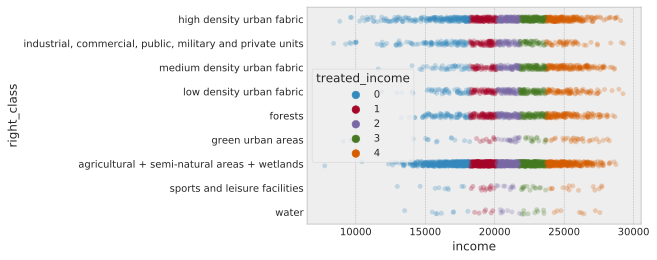

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

sns.stripplot(y="right_class", x="income", hue="treated_income",orient="h",
              data=full_im_df_ua.sample(5000), jitter=True,
              alpha=.25, zorder=1);

In [8]:
full_im_df_ua["proxy_class"] = [(x,y) for x,y in full_im_df_ua[["treated_income","right_class"]].values]
full_im_df_ua = full_im_df_ua.sample(frac=1)
train_test_split = np.floor(full_im_df_ua.shape[0]*TRAIN_TEST_FRAC).astype(int)
train_im_df = full_im_df_ua.iloc[:train_test_split]
test_im_df = full_im_df_ua.iloc[train_test_split:]

train_image_count = int(train_test_split*(1-VAL_SPLIT))
val_image_count = int(train_test_split*VAL_SPLIT)
test_image_count = test_im_df.shape[0]

full_im_df_ua["proxy_ind"] = 1
full_im_df_ua.pivot_table(index="right_class",columns="treated_income",values="proxy_ind",aggfunc=sum,margins=True)

treated_income                                          0      1      2  \
right_class                                                               
agricultural + semi-natural areas + wetlands        48510  52624  47863   
forests                                              6480   7734   8807   
green urban areas                                    1586   1028   1138   
high density urban fabric                           19817  17052  18807   
industrial, commercial, public, military and pr...   9349   5548   5347   
low density urban fabric                             4927   5711   6330   
medium density urban fabric                          4444   5898   7210   
sports and leisure facilities                        1352    921   1004   
water                                                 728    677    674   
All                                                 97193  97193  97180   

treated_income                                          3      4     All  
right_class                                                               
agricultural + semi-natural areas + wetlands        42373  29498  220868  
forests                                              9640  11710   44371  
green urban areas                                    1625   2626    8003  
high density urban fabric                           20861  22738   99275  
industrial, commercial, public, military and pr...   4755   4010   29009  
low density urban fabric                             7006   8563   32537  
medium density urban fabric                          9174  15500   42226  
sports and leisure facilities                        1110   1799    6186  
water                                                 657    753    3489  
All                                                 97201  97197  485964

#### ImageDataGenerator

In [24]:
proxy_datagen = ImageDataGenerator(preprocessing_function=my_preprocessor, horizontal_flip=True,vertical_flip=True)

In [12]:
proxy_generator = proxy_datagen.flow_from_dataframe(
        train_im_df,
        directory=OUTPUT_DIR,
        x_col="path2im",
        y_col="proxy_class",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE,
        interpolation="bicubic",
        subset="training",
        class_mode='categorical')

Found 388771 images belonging to 14 classes.


In [25]:
proxy_generator = proxy_datagen.flow_from_dataframe(
        train_im_df.head(1000),
        directory=OUTPUT_DIR,
        x_col="path2im",
        y_col="proxy_class",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE,
        interpolation="bicubic",
        subset="training",
        class_mode='categorical')

Found 1000 images belonging to 14 classes.


In [23]:
data = []
nb = 1000
for i in tqdmn(range(nb)):
    ses_im, ses_class  = next(proxy_generator)
    data.append(ses_class)
stat_batch = np.stack(data)

100%|██████████| 1000/1000 [18:15<00:00,  1.09s/it]


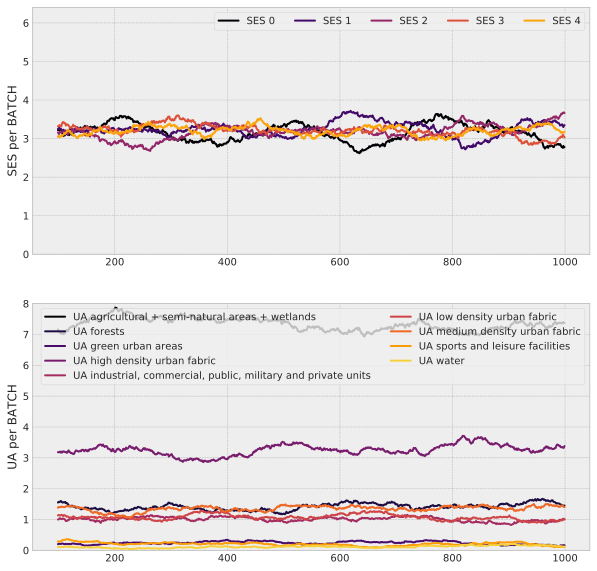

In [76]:
f,axes = plt.subplots(2,1,figsize=(10,10));
window = 100
nb_ses = 5
nb_ua = 9
dic_class = {v:k for k,v in proxy_generator.class_indices.items()}
ses_batch_info = np.sum(stat_batch[:,:,:nb_ses],axis=1)
ua_batch_info = np.sum(stat_batch[:,:,nb_ses:],axis=1)
for i in range(nb_ses):
    s = pd.Series(ses_batch_info[:,i])
    axes[0].plot(range(ses_batch_info.shape[0]),np.array(s.rolling(window).mean()),"-o",
                 color=plt.cm.inferno(float(i)/nb_ses),
                 markersize=.1,label="SES %s"%dic_class[i]);
    axes[0].legend(ncol=nb_ses);
    axes[0].set_ylim([0,.4*BATCH_SIZE]);
    axes[0].set_ylabel("SES per BATCH");
    
for i in range(nb_ua):
    s = pd.Series(ua_batch_info[:,i])
    axes[1].plot(range(ua_batch_info.shape[0]),np.array(s.rolling(window).mean()),"-o",
                 color=plt.cm.inferno(float(i)/nb_ua),
                 markersize=.1,label="UA %s"%dic_class[nb_ses + i]);
    axes[1].legend(ncol=2);
    axes[1].set_ylim([0,.5*BATCH_SIZE]);
    axes[1].set_ylabel("UA per BATCH");

#### BalancedImageDataGenerator

In [13]:
bal_proxy_datagen = BalancedImageDataGenerator(preprocessing_function=my_preprocessor,
                                       horizontal_flip=True,vertical_flip=True)

In [ ]:
BATCH_SIZE = 64
bal_proxy_generator = bal_proxy_datagen.flow_from_dataframe(
        train_im_df,
        directory=OUTPUT_DIR,
        x_col="path2im",
        y_col="proxy_class",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE,
        interpolation="bicubic",
        subset="training",
        class_mode='multi_categorical')

In [ ]:
BATCH_SIZE = 64
bal_proxy_generator = bal_proxy_datagen.flow_from_dataframe(
        train_im_df,
        directory=OUTPUT_DIR,
        x_col="path2im",
        y_col="proxy_class",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE,
        interpolation="bicubic",
        subset="training",
        class_mode='categorical')

In [ ]:
data = []
nb = 1000
for i in tqdmn(range(nb)):
    ses_im, ses_class  = next(bal_proxy_generator)
    data.append(ses_class)

stat_batch = np.stack(data)

In [ ]:
f,axes = plt.subplots(2,1,figsize=(10,10));
window = 100
nb_ses = 5
nb_ua = 9
dic_class = {v:k for k,v in bal_proxy_generator.class_indices.items()}
ses_batch_info = np.sum(stat_batch[:,:,:nb_ses],axis=1)
ua_batch_info = np.sum(stat_batch[:,:,nb_ses:],axis=1)
for i in range(nb_ses):
    s = pd.Series(ses_batch_info[:,i])
    axes[0].plot(range(ses_batch_info.shape[0]),i*0.1 + np.array(s.rolling(window).mean()),"-o",
                 color=plt.cm.inferno(float(i)/nb_ses),
                 markersize=.1,label="SES %s"%dic_class[i]);
    axes[0].legend(ncol=nb_ses);
    axes[0].set_ylim([0,.4*BATCH_SIZE]);
    axes[0].set_ylabel("SES per BATCH");
    
for i in range(nb_ua):
    s = pd.Series(ua_batch_info[:,i])
    axes[1].plot(range(ua_batch_info.shape[0]),i*0.2 +np.array(s.rolling(window).mean()),"-o",
                 color=plt.cm.inferno(float(i)/nb_ua),
                 markersize=.1,label="UA %s"%dic_class[nb_ses + i]);
    axes[1].legend(ncol=2);
    axes[1].set_ylim([0,.5*BATCH_SIZE]);
    axes[1].set_ylabel("UA per BATCH");

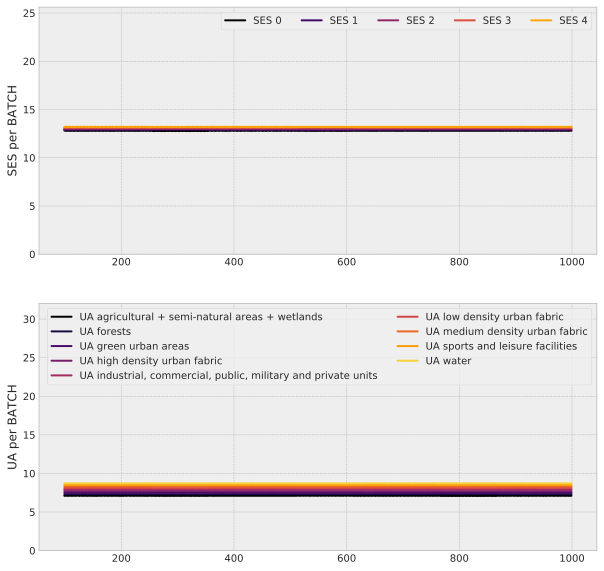

In [13]:
f,axes = plt.subplots(2,1,figsize=(10,10));
window = 100
nb_ses = 5
nb_ua = 9
dic_class = {v:k for k,v in bal_proxy_generator.class_indices.items()}
ses_batch_info = np.sum(stat_batch[:,:,:nb_ses],axis=1)
ua_batch_info = np.sum(stat_batch[:,:,nb_ses:],axis=1)
for i in range(nb_ses):
    s = pd.Series(ses_batch_info[:,i])
    axes[0].plot(range(ses_batch_info.shape[0]),i*0.1 + np.array(s.rolling(window).mean()),"-o",
                 color=plt.cm.inferno(float(i)/nb_ses),
                 markersize=.1,label="SES %s"%dic_class[i]);
    axes[0].legend(ncol=nb_ses);
    axes[0].set_ylim([0,.4*BATCH_SIZE]);
    axes[0].set_ylabel("SES per BATCH");
    
for i in range(nb_ua):
    s = pd.Series(ua_batch_info[:,i])
    axes[1].plot(range(ua_batch_info.shape[0]),i*0.2 +np.array(s.rolling(window).mean()),"-o",
                 color=plt.cm.inferno(float(i)/nb_ua),
                 markersize=.1,label="UA %s"%dic_class[nb_ses + i]);
    axes[1].legend(ncol=2);
    axes[1].set_ylim([0,.5*BATCH_SIZE]);
    axes[1].set_ylabel("UA per BATCH");

#### Model Balanced Training

In [28]:
NB_SES_CLASS = 5
NB_UA_CLASS = 10

In [28]:
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Concatenate

In [30]:
image_input = Input(shape=INPUT_SHAPE)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input,)
# add a global spatial average pooling layer
x = base_model.output
x = Flatten()(x)
# and a final logistic layer
ses_predictions = Dense(5, activation='softmax')(x)
ua_predictions = Dense(9, activation='softmax')(x)
predictions = Concatenate()([ses_predictions, ua_predictions])

In [ ]:
model = Model(inputs=image_input, outputs=predictions)
model.compile(optimizer=Adam(lr=INITIAL_LR), loss="categorical_crossentropy",
              #loss_weights=[1.0/NB_SES_CLASS, 1.0/NB_UA_CLASS],
              metrics=[fmeasure,recall,precision])

In [ ]:
# this is the model we will train
model = Model(inputs=image_input, outputs=predictions)
model.compile(optimizer=Adam(lr=INITIAL_LR), loss="categorical_crossentropy", metrics=[fmeasure,recall,precision])

In [ ]:
ImageDataGenerator.flow_from_dataframe?

In [ ]:
def make_grid(im_batch, lab_batch, nrow):
    # make the mini-batch of images into a grid
    batch_size, w, h, c = im_batch.shape
    nb_cols = min(nrow, batch_size)
    nb_rows = int(np.ceil(float(batch_size) / nb_cols))
    f,axes = plt.subplots(nb_rows,nb_cols,figsize=(nb_cols*3,nb_rows*3))
    plt.setp(axes,xticks=[],yticks=[])
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=.05,hspace=.05)
    k = 0
    for i_row in np.arange(nb_rows):
        for i_col in np.arange(nb_cols):
            axes[i_row,i_col].imshow(im_batch[k])
            axes[i_row,i_col].text(x=200,y=200,s="%d"%np.where(l_test[k])[0][0],#l_test[k],#
                                   color="white",
                                   bbox=dict(facecolor='red', alpha=0.5))
            k+=1
            if k >= batch_size:
                break

In [34]:
print("Defining and Compiling Model")
image_input = Input(shape=INPUT_SHAPE)
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input,)
# add a global spatial average pooling layer
x = base_model.output
x = Flatten()(x)
# and a final logistic layer

ses_predictions = Dense(5, activation='softmax',name="ses_output")(x)
ua_predictions = Dense(9, activation='softmax',name="ua_output")(x)
#predictions = Concatenate()([ses_predictions, ua_predictions])

# this is the model we will train
model = Model(inputs=image_input,outputs=[ses_predictions, ua_predictions]) #outputs=predictions)

# Load the last best model
dic_load_model = {
    "precision":precision,
    "recall":recall,
    "fbeta_score":fbeta_score,
    "fmeasure":fmeasure
}
model = load_model(
    MODEL_OUTPUT_DIR + "lastbest-0.hdf5",
    custom_objects=dic_load_model)

Defining and Compiling Model


In [35]:
density = full_im_df_ua.ind_c
class_thresholds = [np.percentile(density,k) for k in np.linspace(0,100,NB_CLASSES +1 )]
x_to_class = np.digitize(density,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_CLASSES
full_im_df_ua["treated_density"] = [ str(y-1) for y in x_to_class ]

In [68]:
full_im_df_ua["proxy_class"] = [(x,y) for x,y in full_im_df_ua[["treated_density","right_class"]].values]
full_im_df_ua = full_im_df_ua.sample(frac=1)
proxy_datagen = ImageDataGenerator(preprocessing_function=my_preprocessor)
BATCH_SIZE = 1
bal_proxy_generator = proxy_datagen.flow_from_dataframe(
        full_im_df_ua.head(1000),
        directory=OUTPUT_DIR,
        x_col="path2im",
        y_col="proxy_class",
        target_size=IMG_SIZE,
        color_mode ="rgb",
        shuffle=True,
        batch_size=BATCH_SIZE,
        interpolation="bicubic",
        subset="training",
        class_mode='categorical')

Found 1000 images belonging to 14 classes.


In [50]:
emb = Model(inputs=model.input,outputs=model.get_layer("flatten_1").output)

In [55]:
emb.predict_generator?

In [69]:
data = emb.predict_generator(bal_proxy_generator,steps=1000,verbose=1)

1000/1000 [==============================] - 54s 54ms/step


Counter({4: 4996, 1: 4517, 0: 4960, 3: 5113, 2: 5414})

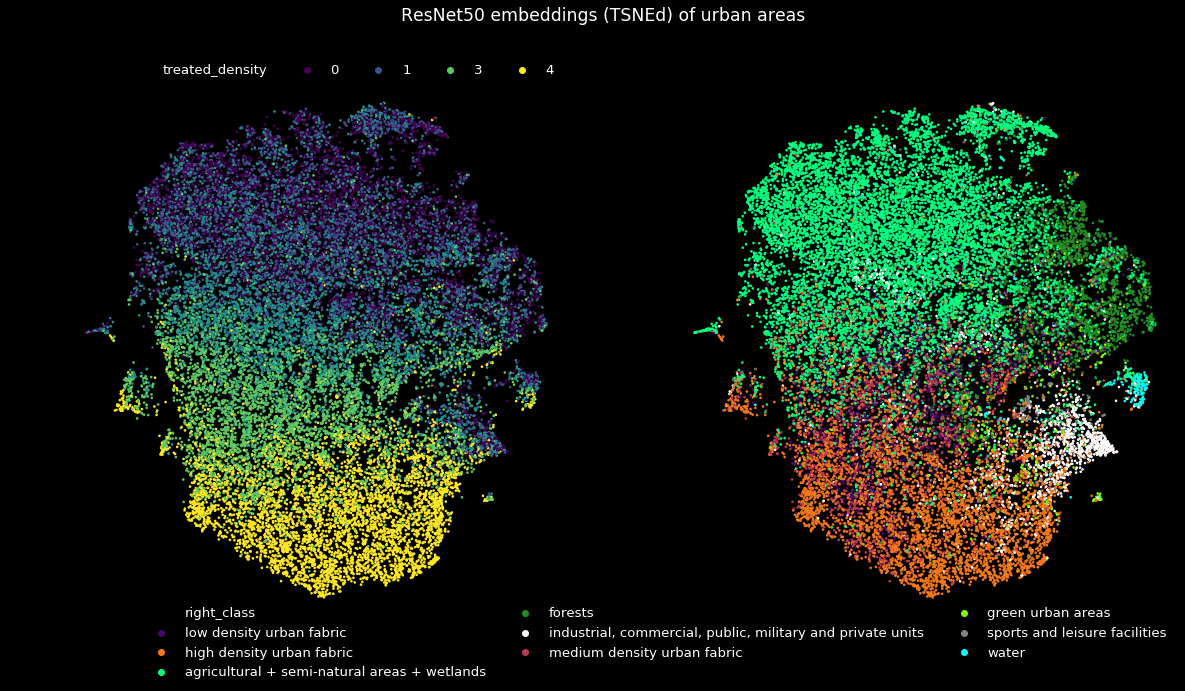

Counter({2: 5096, 1: 5014, 4: 5007, 3: 4895, 0: 4988})

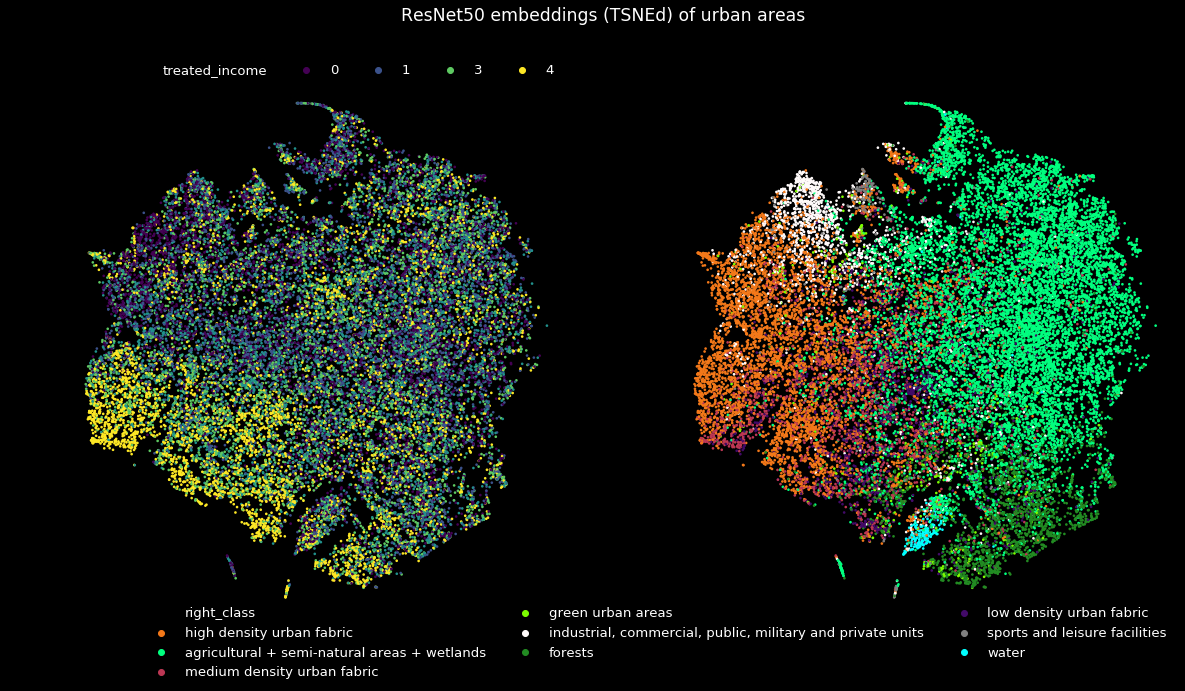

# Cifar10 Example

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import os

from keras.datasets import cifar10

from sklearn.preprocessing import MinMaxScaler
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD, Adam
import pandas as pd
import os
from tqdm import tqdm as tqdmn
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras import metrics
from keras import backend as K
from keras.models import Model
import sys
from skimage import io
import multiprocessing
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

In [ ]:
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 21))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def fbeta_score(y_true, y_pred, beta=1): 
    if beta < 0: 
        raise ValueError('The lowest choosable beta is zero (only precision).') 
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0: 
        return 0 
    p = precision(y_true, y_pred) 
    r = recall(y_true, y_pred) 
    bb = beta ** 2 
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon()) 
    return fbeta_score 

def fmeasure(y_true, y_pred): 
    return fbeta_score(y_true, y_pred, beta=1) 

In [ ]:
img_width, img_height = 32, 32
batch_trainsize=32 #decrease if you machine has low gpu or RAM
batch_testsize=32 #otherwise your code will crash.
nb_epoch = 1

#SGD: Gradient Descent with Momentum and Adaptive Learning Rate
#for more, see here: https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/
learningrate=1e-3 #be careful about this parameter. 1e-3 to 1e-8 will train better while learningrate decreases.
momentum=0.8
num_classes = 10

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
from keras.layers import Input
image_input = Input(shape=(img_width, img_height, 3))
model = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')
x = model.get_layer('res5a_branch2a').input
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=image_input,outputs= out)

for layer in custom_resnet_model.layers[:]:
	layer.trainable = True

custom_resnet_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learningrate),
              metrics=['accuracy',fmeasure,recall,precision])

hist = custom_resnet_model.fit(X_train, y_train, batch_size=batch_trainsize, epochs=4, verbose=1,
                               validation_data=(X_test, y_test))

In [ ]:
pred_test = custom_resnet_model.predict(X_test)
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(np.argmax(y_test,axis=1),np.argmax(pred_test,axis=1),list(range(10)));

In [ ]:
#This doesn't work
from keras.applications.resnet50 import ResNet50

image_input = Input(shape=(img_width, img_height, 3))
base = ResNet50(input_tensor=image_input, include_top=False,weights='imagenet')
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base.inputs, outputs=predictions)
model.compile(optimizer=SGD(lr=learningrate, momentum=momentum),loss="categorical_crossentropy",
              metrics=[fmeasure,recall,precision])
hist = model.fit(X_train, y_train, batch_size=batch_trainsize, epochs=4, verbose=1
                 ,validation_data=(X_test, y_test))

In [ ]:
hist.history['val_loss']

In [ ]:
13

In [ ]:
#This doesn't work
from keras.applications.resnet50 import ResNet50
base =  ResNet50(include_top=False, weights=None, input_shape=(img_width, img_height, 3))
x = base.output
# Add a global average pooling layer
x = GlobalAveragePooling2D(name='avg_pool')(x)
# Add fully connected output layer with sigmoid activation for multi label classification
outputs = Dense(num_classes, activation='softmax', name='fc9')(x)
model = Model(inputs=base.inputs, outputs=outputs)
model.compile(optimizer=SGD(lr=learningrate, momentum=momentum),loss="categorical_crossentropy",metrics=[fmeasure,recall,precision])
hist = model.fit(X_train, y_train, batch_size=batch_trainsize, epochs=1, verbose=1
                 ,validation_data=(X_test, y_test))

In [ ]:
history = model.fit
    generator=train_generator,
    steps_per_epoch=train_image_count // BATCH_SIZE,
    epochs=MAX_EPOCH - global_epoch,
    validation_data=val_generator,
    validation_steps=val_image_count // BATCH_SIZE,
    workers=10,
    verbose=1,
    callbacks=[tensorboard, model_checkpoint, early_stopping, reduce_lr, csv_logger],
    shuffle=False)
    


# PyTorch: models_utils.py

In [ ]:
# Library Imports
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.models as models
from torchvision import transforms, utils,datasets
import torch.utils.data as data
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm as tqdmn
import torch.nn as nn
from sklearn.preprocessing import (MinMaxScaler,StandardScaler,)
import skimage
import matplotlib.pyplot as plt
from collections import OrderedDict
from decimal import Decimal
import sys
from tensorboardX import SummaryWriter
from sklearn import metrics
base_dir = "/warehouse/COMPLEXNET/jlevyabi/"
sys.path.append(base_dir + "SATELSES/equirect_proj_test/cnes/python_files/")
import pandas as pd
from dataset_utils import DigitalGlobeFrance
from model_utils import train, test , load_checkpoint, save_checkpoint

In [ ]:
classic_resnet_size = 224
batch_sz = 16
nb_channels = 3
cpu_counts = os.cpu_count()
cpu_dataloader = int(0.3*cpu_counts)

params = pd.read_csv(python_dir + "params.csv",sep=",")
# [(desired_size, crop, multiple_crops, pretrained )]
row = params.iloc[0]

#### w_desired = h_desired = row.desired_size
transform_lists = []
# Color Channel Mods
if row.jitter:
    transform_lists.append(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))

# Size Mod
if row.crop:
    if row.multiple_crops:
        transform_lists.append(transforms.FiveCrop((w_desired,h_desired)))
    else:
        transform_lists.append(transforms.RandomCrop((w_desired,h_desired)))
else:
    transform_lists.append(transforms.Resize((w_desired,h_desired)))

# Tensorize
transform_lists.append(transforms.ToTensor())
transform = transforms.Compose(transform_lists)

In [ ]:
# Generate Dataset
dg_dataset = DigitalGlobeFrance(output_dir, dic_im2target, transform=transform)
train_idx, val_idx, test_idx = dg_dataset.train_test_split(frac=0.4)
train_loader = DataLoader(dg_dataset, batch_size=batch_sz, num_workers=cpu_dataloader, sampler=train_idx)
val_loader = DataLoader(dg_dataset, batch_size=batch_sz, num_workers=cpu_dataloader, sampler=val_idx)
test_loader = DataLoader(dg_dataset, batch_size=batch_sz, num_workers=cpu_dataloader, sampler=test_idx)
print("Done Loading")

## Things to check:
 - Is image associated to correct ses label?
 - Is image label corresponding to correct geographical position?
 - Run in Keras: is it giving the same erratic learning behaviour? If doesn't what is the difference between Keras/PyTorch version of the code?

In [ ]:
# Model Parameters
lr = 1e-3
momentum = 0.9
weight_decay = 1.0e-3
start_epoch, max_epochs = (0, 10)
gamma = 0.1
st_size = 5
ckpt_dir = output_dir + "../model_data/resnet_random_classic_crop/"

# Model Definition
print("Defining Model")
model = models.resnet50(pretrained=row.pretrained)
last_layer_in_fts = list(model.children())[-1].in_features
model.fc = nn.Linear(last_layer_in_fts,out_features=NB_CLASSES,bias=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
preds_, labels_ = [], []

In [ ]:
preds_.extend(model(test[0].to(device)).cpu().detach().numpy().tolist())
labels_.extend(test[-1].data.cpu().numpy().tolist())

In [ ]:
metrics.accuracy_score(labels_,np.argmax(preds_,axis=1))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=gamma, step_size=st_size)
metrics = 
writer = SummaryWriter(log_dir=log_dir + "resnet50_jitter_%d_desired_size_%d_crop_%d_multiple_%d_pretrained_%d"%(int(row.jitter),int(row.desired_size),int(row.crop),
                                                                                                                     int(row.multiple_crops),int(row.pretrained)))

# Model Training
print("Training Model")
train_test_model, train_test_state = train(model,train_loader,val_loader,
                                           criterion,optimizer,metrics, scheduler,
                                           device,ckpt_dir,num_epochs=max_epochs,writer=writer,multiple_crops=row.multiple_crops)
writer.close()

# Model Testing
print("Testing Model")
metrics = metrics.accuracy_score
test_score_1 = test(test_loader, model, criterion, metrics, device, multiple_crops=row.multiple_crops)
metrics = metrics.mean_absolute_error
test_score_2 = test(test_loader, model, criterion, metrics, device, multiple_crops=row.multiple_crops)
